In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from IPython.display import clear_output

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

import random

print(device_gpu)

cuda:0


In [3]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [4]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [5]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', '').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', '').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

In [6]:
cleanEnglishVocab("bio tech")

['BIO', 'TECH']

In [7]:
cleanHindiVocab("बायो टेक")

['बायो', 'टेक']

In [8]:
X = []
y = []

with open('crowd_transliterations.hi-en.txt', 'r') as f: 
    j = 0
    for line in f:
        j += 1
        line = line.split('\t')
        name = cleanEnglishVocab(line[0].strip())
        label = cleanHindiVocab(line[1].strip())

        if(len(name) != len(label)) :
          print('Skipping: ', line[0].strip(), ' - ', line[1].strip())
          continue

        if(len(name) == 0) :
          continue
          
        X.append(name[0])
        y.append(label[0])

Skipping:  ek  -  1
Skipping:  ikkis  -  21
Skipping:  do  -  2
Skipping:  8.01  -  अब्दुस
Skipping:  डॅम्प्सकीबेसेल्सकॅबेट  -  डॅम्प्सकीबेसेल्सकॅबेट
Skipping:  chaar  -  4
Skipping:  ऐ  -  ऐध


In [9]:
train_data = []
target_data = []
test_data = []
test_target_data = []

list1 = random.sample(range(0, len(X)), int(len(X) * 0.1))

for i in range(len(list1)) :
  test_data.append(X[list1[i]])
  test_target_data.append(y[list1[i]])
  X[list1[i]] = "-1-1-1"

for i in range(len(X)) :
  if X[i] != "-1-1-1" :
    train_data.append(X[i])
    target_data.append(y[i])

print(train_data)
print(test_data)

['HAJAGIREE', 'CHEKAANV', 'SPINAGAARN', 'MEDAL', 'CHETTHINAAD', 'HARI', 'BHOOMI', 'YAANHMSAN', 'HANUMAAN', 'ABHINETRI', 'TO', 'SIKKIM', 'ABDUS', 'ALVAR', 'KAPIL', 'DEV', 'BAAFLAYER', 'CAPILANO', 'SUSPENSION', 'GRAHAM', 'STEPHENSON', 'ART', 'MUSEUM', 'KAMLESH', 'EFFI', 'AWARDS', 'WARREN', 'VISNESKI', 'BRUS', 'AIGAR', 'JAUN', 'MILTAN', 'AI', 'YAAD', 'ABDUS', 'SAMAD', 'ERNAA', 'SHREE', 'RAM', 'BHARAT', 'MILAP', 'ROCI', 'KEDY', 'MADIHAH', 'AAHLAD', 'BORNHAM', 'FORT', 'ERMA', 'MERA', 'LALKAR', 'APOORVA', 'CIVILLA', 'RANCHI', 'KAPILA', 'MODESTI', 'ELAN', 'VELS', 'ABHISHOK', 'BEDARD', 'JAMANA', 'KYA', 'JAANE', 'AADITYA', 'SAVITSHRI', 'ABOT', 'INDIA', 'IRFAN', 'SAMEDEMOSE', 'CHAARSEE', 'MAHAFHOOJ', 'GARDI', 'KOFARE', 'PEROOD', 'KOVLIN', 'TIRUPATI', 'BHATTI', 'GURDWARA', 'BETMA', 'ZAPATA', 'BHANWAR', 'PASSENGER', 'ADAS', 'ILENAABAAD', 'REEL', 'INTIKAAM', 'KEE', 'AAG', 'MAIJAR', 'ARAWALEE', 'ROD', 'THAYER', 'SENTAEMS', 'LUT', 'SHYAMA', 'WILKIN', 'DARVIN', 'YATIM', 'JOHN', 'PAN', 'GUA', 'SIPINKUG

In [10]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    print(train_data[i] + ' - ' + target_data[i])

Train Set Size:	 13420
Test Set Size:	 1491

Sample data from train-set:
HAJAGIREE - हजगिरी
CHEKAANV - चेकॉव
SPINAGAARN - स्पिनगार्न
MEDAL - मेडल
CHETTHINAAD - चेत्तिनाद
HARI - हरी
BHOOMI - भूमि
YAANHMSAN - थॉम्सन
HANUMAAN - हनुमान
ABHINETRI - अभिनेत्री


In [11]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [12]:
eng_rep = word_rep("ARAB", eng_alpha2index)
print("ARAB", eng_rep)

ARAB tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [13]:
hindi_gt = gt_rep(target_data[0], hindi_alpha2index)
print(target_data[0], hindi_gt)

हजगिरी tensor([[58],
        [29],
        [24],
        [64],
        [49],
        [65],
        [ 0]])


In [14]:
def calc_accuracy(net, test_data, test_target_data, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i], test_target_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        
        input = word_rep(eng, eng_alpha2index)
        outputs = net(input, gt.shape[0])
        
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [15]:
def train_batch(net,  train_data, test_data, target_data, test_target_data, opt, criterion, batch_size, index, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    
    # n = random.randint(0, len(train_data) - batch_size - 1)
    n = index * 64

    eng_batch = []
    hindi_batch = []
    for i in range(n, n+batch_size) :
      eng_batch.append(train_data[i])
      hindi_batch.append(target_data[i] )  
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(eng_batch[i], eng_alpha2index, device)
        gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss
        
    opt.step()
    return total_loss/batch_size

In [16]:
MAX_OUTPUT_CHARS = 30
class EncoderDecoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(EncoderDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder = nn.LSTM(input_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)
        
        self.dropout = nn.Dropout(p=0.3)

        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

        # encoder
        encoder_outputs, hidden = self.encoder(input)
        encoder_outputs = self.dropout(encoder_outputs)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        
        # decoder
        decoder_state = hidden
        # start of sequence
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)    
        
        outputs = []
        U = self.U(encoder_outputs)
        U = self.dropout(U)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state[0].view(1, -1).repeat(encoder_outputs.shape[0], 1))
            W = self.dropout(W)

            V = self.attn(torch.tanh(U + W))
            V = self.dropout(V)

            attn_weights = F.softmax(V.view(1, -1), dim = 1) 
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            
            embedding = self.out2hidden(decoder_input)
            embedding = self.dropout(embedding)

            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)
                
            out, decoder_state = self.decoder(decoder_input, decoder_state)
            out = self.dropout(out)
                
            out = self.h2o(decoder_state[0])
            out = self.dropout(out)

            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [17]:
def train_setup(net,  train_data, test_data, target_data, test_target_data, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    test_loss_arr = np.zeros(n_batches + 1)
    accuracy = 0
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net,  train_data, test_data, target_data, test_target_data, opt, criterion, batch_size, i%(int(len(train_data) / batch_size)), device = device, teacher_force = i<teacher_force_upto ))/(i + 1)

        if(i % 500 == 0) :
            test_accuracy = calc_accuracy(net, test_data, test_target_data) * 100
            print('Accuracy on Test Data', test_accuracy)
            accuracy = calc_accuracy(net, train_data, target_data) * 100
            print('Accuracy on Train Data', accuracy)

        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, ' :- Train_Loss : ', loss_arr[i])
            print('Last Accuracy on Test Data : ', test_accuracy)
            print('Last Accuracy on Train Data : ', accuracy)

            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

In [18]:
net = EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 7999  :- Train_Loss :  0.2002430558204651
Last Accuracy on Test Data :  72.2366261802882
Last Accuracy on Train Data :  88.67438791480545


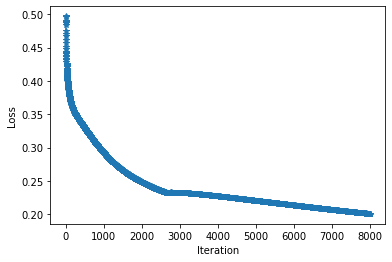

array([0.        , 0.49018776, 0.4881897 , ..., 0.20025118, 0.20024306,
       0.20023502])

In [19]:
train_setup(net,  train_data, test_data, target_data, test_target_data, lr=0.001, n_batches=8000, batch_size = 64, display_freq=10, device = device_gpu)

In [20]:
net_saved = net

In [21]:
accuracy = calc_accuracy(net, test_data, test_target_data) * 100
print('Accuracy on Test Data', accuracy)

accuracy = calc_accuracy(net, train_data, target_data) * 100
print('Accuracy on Train Data', accuracy)

Accuracy on Test Data 72.09637519496674
Accuracy on Train Data 90.31492273226505


In [22]:
def predict(net, test_data, test_target_data, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i], test_target_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        print(eng)
        
        input = word_rep(eng, eng_alpha2index)
        outputs = net(input, gt.shape[0])
        
        for i in range(len(outputs)):
          if list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(outputs[i]))] != '-PAD-' :
            print(list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(outputs[i]))], end ="")
          else :
            break
        print("\n\n")

    return

In [23]:
temp_data = train_data[:10]
temp_target_data = target_data[:10]
predict(net, temp_data, temp_target_data)

HAJAGIREE
हजगीरी


CHEKAANV
चेकॉवव


SPINAGAARN
स्पीनगार्न


MEDAL
मेडल


CHETTHINAAD
चेत्तिनाद


HARI
हरी


BHOOMI
भूमि


YAANHMSAN
थॉम्सन


HANUMAAN
हनुमान


ABHINETRI
अभिनेत्री




In [30]:
# Enter your own inputs here
temp_data = []
temp_data.append("ANUJ")

temp_target_data = []
temp_target_data.append("अनुज")

predict(net, temp_data, temp_target_data)


temp_data = []
temp_data.append("MUMBAI")

temp_target_data = []
temp_target_data.append("मुम्बई")

predict(net, temp_data, temp_target_data)



temp_data = []
temp_data.append("VIKASH")

temp_target_data = []
temp_target_data.append("विकाश")

predict(net, temp_data, temp_target_data)





ANUJ
अनुज


MUMBAI
मुम्बाई


VIKASH
विकाश




In [28]:
while True:
  temp_data = []
  temp_data.append(input("Enter English Word OR 0 to Exit :- "))

  if temp_data[0] == '0' :
    break
  temp_target_data = []
  temp_target_data.append("अअअअअअअअअअअअअअअअअअअअअअअअअअअअअअ")
  predict(net, temp_data, temp_target_data)

Enter English Word OR 0 to Exit :- 0
